# Setup

In [76]:
import copy
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as mplc
import seaborn as sns
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from tqdm import tqdm
import geopandas as gp
import pooch
import regionmask

# Configuration

In [78]:
#Verbose output?
verbose='true'

#Fixes masks on default ocean basin and continents masks. If you load your own, this should be turned off.
maskfixes='true'

#Choose ERA5 or NCEP2. This switch also selects the eval/???? subfolders, so do not mix and match as this 
#would lead to incorrect results.
reanalysis='ERA5'

#Define paths
obs_path='obs/'
model_path='/p/project/chhb19/streffing1/software/cmpi-tool/input/'
out_path='output/'
eval_path='eval/'+reanalysis+'/'
time = '198912-201411'

# Setup variables (turn off variables for analysis by instancing with optional argument active=False)
class variable:
    def __init__ (self, name, obs, depths, domain='mixed', active=True):
        self.name = name
        self.obs = obs
        self.depths = depths
        self.domain = domain
        self.active = active

siconc = variable(name='siconc',obs='OSISAF', depths=['surface'], domain='oce')
pr = variable(name='pr', obs='GPCP', depths=['surface'])
tas = variable(name='tas', obs=reanalysis, depths=['surface'])
clt = variable(name='clt', obs='MODIS', depths=['surface'])
rlut = variable(name='rlut', obs='CERES', depths=['surface'])
uas = variable(name='uas', obs=reanalysis, depths=['surface'])
vas = variable(name='vas', obs=reanalysis, depths=['surface'])
ua = variable(name='ua', obs=reanalysis, depths=['300hPa'])
zg = variable(name='zg', obs=reanalysis, depths=['500hPa'])
zos = variable(name='zos', obs='NESDIS', depths=['surface'])
tos = variable(name='tos', obs='HadISST2', depths=['surface'])
mlotst = variable(name='mlotst', obs='C-GLORSv7', depths=['surface'])
thetao = variable(name='thetao', obs='EN4', depths=['10m','100m','1000m'])
so = variable(name='so', obs='EN4', depths=['10m','100m','1000m'])

obs = [siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]

'''
If don't add all variables to obs for your analysis, the missing ones will be skipped.
However the variables are still present in the pre-generated .csv files. 
We still need to loop over the skipped variables to access the right lines. 
Thus we set number_of_implemented_variables manually, currently to 14.
- If you add more variables and generate new .csv files, increase the number 14 accordingly!
- If you just skip a variable for your analysis, don't change number_of_implemented_variables!
'''
number_of_implemented_variables = 14 


# Some models don't have all variables available. Thus set give each model a name and a variable dictionary
class climate_model:
    def __init__ (self, name, variables):
        self.name = name
        self.variables = variables
        
cmip6 = [
    climate_model(name='ACCESS-CM2',   variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='AWI-CM1-MR',   variables=[        tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='BCC-SM2-MR',   variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CAMS',         variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CanESM5',      variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CAS-ESM2-0',   variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos,                   ]),
    climate_model(name='CESM2',        variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos, mlotst            ]),
    climate_model(name='CIESM',        variables=[        tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
    climate_model(name='CMCC-CM2-SR5', variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CNRM-CM6-1-HR',variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst            ]),
    climate_model(name='E3SM-1-1',     variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='EC-Earth3',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='FGOALS-f3-L',  variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='FIO-ESM-2-0',  variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
    climate_model(name='GISS-E2-1-G',  variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='HadGEM3MM',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='ICON-ESM-LR',  variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='IITM-ESM',     variables=[        tas, clt, pr, rlut, uas, vas, ua, zg,      tos,                   ]),
    climate_model(name='INM5',         variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg,                   thetao, so]),
    climate_model(name='IPSL-CM6A-LR', variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='KIOST-ESM',    variables=[siconc, tas, clt,     rlut, uas, vas, ua, zg, zos, tos, mlotst,           ]),
    climate_model(name='MCMUA1',       variables=[        tas,        pr, rlut, uas, vas, ua, zg,    tos,         thetao, so]),
    climate_model(name='MIROC6',       variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos,                   ]),
    climate_model(name='MPI-ESM1-2-HR',variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='MRI-ESM2-0',   variables=[siconc, tas, clt, pr, rlut, uas, vas,         zos, tos, mlotst, thetao, so]),
    climate_model(name='NESM3',        variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),   
    climate_model(name='NOAA-GFDL',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos,         thetao, so]),
    climate_model(name='NorESM2-MM',   variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='SNU',          variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
    climate_model(name='TaiESM1',      variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
]

ece3= [    
    climate_model(name='EC-Earth3',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
]

awi_cm3_v31= [
    climate_model(name='AWI-CM3-v3.1', variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
]
                  
models = cmip6

eval_models = cmip6


#Select regions 
class region:
    def __init__ (self, name, domain, active=False):
        self.name = name
        self.domain = domain
        self.active = active
        
glob = region(name='glob', domain='mixed')
arctic =  region(name='arctic', domain='mixed')
Atlantic_Basin =  region(name='Atlantic_Basin', domain='ocean')
Asia =  region(name='Asia', domain='land')

complexity = 'boxes'

if complexity == 'boxes':
    regions_select = ['arctic', 'northmid', 'tropics', 'nino34', 'southmid', 'antarctic']
elif complexity == 'boxes_all':
    regions_select = ['glob', 'arctic', 'northmid', 'tropics', 'innertropics', 'nino34', 'southmid', 'antarctic']
elif complexity == 'regions':
    regions_select = ['Atlantic_Basin', 'Pacific_Basin', 'Indian_Basin', 'Arctic_Basin', 'Southern_Ocean_Basin', 
                      'Mediterranean_Basin', 'Asia', 'North_America', 'Europe', 'Africa', 'South_America', 
                      'Oceania', 'Australia', 'Antarctica']
else:
    regions_select = ['Atlantic_Basin', 'Pacific_Basin', 'Indian_Basin', 'Arctic_Basin', 'Southern_Ocean_Basin', 
                      'Mediterranean_Basin', 'Asia', 'North_America', 'Europe', 'Africa', 'South_America', 'Oceania', 
                      'Australia', 'Antarctica','glob', 'arctic', 'northmid', 'tropics', 'innertropics', 'nino34', 
                      'southmid', 'antarctic']

        
#Select seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# Dataloading

In [79]:
# Retrieve Polygons; Read them; Interpolate to 2° x 2° masks; Concat into one DataArray 
file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)
ocean_basins = gp.read_file("geojson/ocean_basins.geojson")

lon = np.arange(0, 360, 2)
lat = np.arange(-90, 90, 2)
continents_masks = regionmask.mask_3D_geopandas(continents, lon, lat)
ocean_basins_masks = regionmask.mask_3D_geopandas(ocean_basins, lon, lat)

ocean_basins_masks['region'==1]
ocean_basins_masks['region']=ocean_basins_masks.region+continents_masks.sizes['region']


In [80]:
# Add simple box masks

#Define regions
boxes={
    'glob' : {
    'lat_min':-90,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'none',},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'red',},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'lightgrey',},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'green',},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'green',},
        
    'nino34' : {
    'lat_min':-5,
    'lat_max':5,
    'lon_min':190,
    'lon_max':240,
    'plot_color':'yellow',},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'pink',},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'blue',},
    
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'pink',},
          
}

# Create lat & lon filters based on box edges
boxlist=[]
for box in boxes:
    boxlist.append(box)
    
boxnum=[]
mask_lat=OrderedDict()
mask_lat=OrderedDict()
n=0
box_masks_np=np.empty(shape=(len(lat),len(lon),len(boxlist)))
for box in boxes:
    mask_lat=np.logical_and(lat>boxes[box]['lat_min'], lat<boxes[box]['lat_max'])
    mask_lon=np.logical_and(lon>boxes[box]['lon_min'], lon<boxes[box]['lon_max'])
    boxnum.append(n+ocean_basins_masks.sizes['region']+continents_masks.sizes['region']) # offset region number 

    
    # Make numpy array with gridded mask
    for i in range(0,len(lat)):
        for j in range(0,len(lon)):
            box_masks_np[i,j,n]=np.logical_and(mask_lat[i],mask_lon[j])
    n+=1     
    
# Same xarray format as complex ocean and continent masks above.
box_masks = xr.DataArray(box_masks_np, 
coords={'lat': lat,'lon': lon,'region': boxnum}, 
dims=["lat", "lon", "region"])


In [81]:
masks=xr.concat((continents_masks,ocean_basins_masks,box_masks),dim="region")

if maskfixes:
    # Create Southern Ocean mask via xor nearby continental masks 
    save_orig = copy.deepcopy(masks.sel(region=12))
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=4)) #South America
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=5)) #Oceania
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=6)) #Australia
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=7)) #Antarctica
    masks[12,:,:] = np.logical_and(masks.sel(region=12), save_orig)

    # Fix the Arctic and Atlantic bleeding into Greenland
    save_orig = copy.deepcopy(masks.sel(region=8))
    masks[8,:,:] = np.logical_xor(masks.sel(region=8), masks.sel(region=1)) 
    masks[8,:,:] = np.logical_and(masks.sel(region=8), save_orig) 


In [82]:
# Store masks as dictrionary for easy access
regions_avail = OrderedDict()


for i in range(0,continents_masks.sizes['region']):
    if verbose:
        print('Mask available for:',i,continents['CONTINENT'][i].replace(' ', '_'))
    regions_avail[continents['CONTINENT'][i].replace(' ', '_')]={ 
        'mask': masks[i]
    }
for i in range(0,ocean_basins_masks.sizes['region']):
    if verbose:
        print('Mask available for:',i,ocean_basins['name'][i].replace(' ', '_'))
    regions_avail[ocean_basins['name'][i].replace(' ', '_')]={ 
        'mask': masks[i+continents_masks.sizes['region']]
    }
for i in range(boxnum[0],boxnum[len(boxnum)-1]+1):
    if verbose:
        print('Mask available for:',i,boxlist[i-boxnum[0]].replace(' ', '_'))
    regions_avail[boxlist[i-boxnum[0]].replace(' ', '_')]={ 
        'mask': masks[i]
    }
    

# Select subset of available regions
regions = OrderedDict()
for r in regions_select:
    if verbose:
        print('Selecting Mask for:',r)
    regions[r] = regions_avail[r]

Mask available for: 0 Asia
Mask available for: 1 North_America
Mask available for: 2 Europe
Mask available for: 3 Africa
Mask available for: 4 South_America
Mask available for: 5 Oceania
Mask available for: 6 Australia
Mask available for: 7 Antarctica
Mask available for: 0 Atlantic_Basin
Mask available for: 1 Pacific_Basin
Mask available for: 2 Indian_Basin
Mask available for: 3 Arctic_Basin
Mask available for: 4 Southern_Ocean_Basin
Mask available for: 5 Mediterranean_Basin
Mask available for: 14 glob
Mask available for: 15 arctic
Mask available for: 16 northmid
Mask available for: 17 tropics
Mask available for: 18 innertropics
Mask available for: 19 nino34
Mask available for: 20 southmid
Mask available for: 21 antarctic
Selecting Mask for: arctic
Selecting Mask for: northmid
Selecting Mask for: tropics
Selecting Mask for: nino34
Selecting Mask for: southmid
Selecting Mask for: antarctic


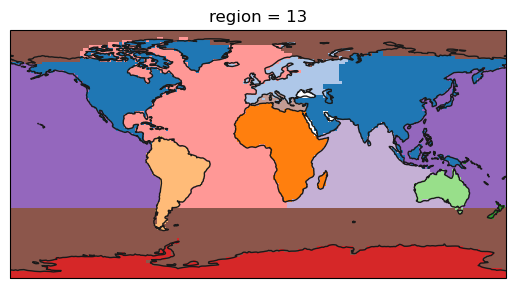

In [83]:
cm = plt.get_cmap('tab20')
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
for i in range(0,ocean_basins_masks.sizes['region']+continents_masks.sizes['region']):
    cmap = mplc.ListedColormap(['#FFFFFF00', cm(1*i/masks.sizes['region'])])
    masks.sel(region=i).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        cmap=cmap,
    )

ax.coastlines(color="0.1");

In [84]:
print('Loading obs data')

ds_obs = OrderedDict()

for var in obs:
    for depth in var.depths:
        for seas in seasons:
            if verbose == 'true':
                print('loading '+obs_path+var.name+'_'+var.obs+'_'+depth+'_'+seas+'.nc')

            intermediate = xr.open_dataset(obs_path+var.name+'_'+var.obs+'_'+depth+'_'+seas+'.nc')
            ds_obs[var.name,depth,seas] = intermediate.compute()
            try:
                ds_obs[var.name,depth,seas]=ds_obs[var.name,depth,seas].drop('time_bnds')
            except:
                pass
            try:
                ds_obs[var.name,depth,seas]=ds_obs[var.name,depth,seas].drop('time_bnds_2')
            except:
                pass
            try:
                ds_obs[var.name,depth,seas]=ds_obs[var.name,depth,seas].drop('depth')
            except:
                pass
            

Loading obs data
loading obs/siconc_OSISAF_surface_MAM.nc
loading obs/siconc_OSISAF_surface_JJA.nc
loading obs/siconc_OSISAF_surface_SON.nc
loading obs/siconc_OSISAF_surface_DJF.nc
loading obs/tas_ERA5_surface_MAM.nc
loading obs/tas_ERA5_surface_JJA.nc
loading obs/tas_ERA5_surface_SON.nc
loading obs/tas_ERA5_surface_DJF.nc
loading obs/clt_MODIS_surface_MAM.nc
loading obs/clt_MODIS_surface_JJA.nc
loading obs/clt_MODIS_surface_SON.nc
loading obs/clt_MODIS_surface_DJF.nc
loading obs/pr_GPCP_surface_MAM.nc
loading obs/pr_GPCP_surface_JJA.nc
loading obs/pr_GPCP_surface_SON.nc
loading obs/pr_GPCP_surface_DJF.nc
loading obs/rlut_CERES_surface_MAM.nc
loading obs/rlut_CERES_surface_JJA.nc
loading obs/rlut_CERES_surface_SON.nc
loading obs/rlut_CERES_surface_DJF.nc
loading obs/uas_ERA5_surface_MAM.nc
loading obs/uas_ERA5_surface_JJA.nc
loading obs/uas_ERA5_surface_SON.nc
loading obs/uas_ERA5_surface_DJF.nc
loading obs/vas_ERA5_surface_MAM.nc
loading obs/vas_ERA5_surface_JJA.nc
loading obs/vas_ERA

In [85]:
print('Loading model data')

ds_model = OrderedDict()

for model in tqdm(models):
    for var in model.variables:
        for depth in var.depths:
            for seas in seasons:
                if verbose == 'true':
                    print('loading '+model_path+var.name+'_'+model.name+'_'+time+'_'+depth+'_'+seas+'.nc')
                intermediate = xr.open_mfdataset(model_path+var.name+'_'+model.name+'_'+time+'_'+depth+'_'+seas+'.nc')
                intermediate = intermediate.squeeze(drop=True)
                ds_model[var.name,depth,seas,model.name] = intermediate.compute()
                try:
                    ds_model[var.name,depth,seas,model.name]=ds_model[var.name,depth,seas,model.name].drop('time_bnds')
                except:
                    pass
                try:
                    ds_model[var.name,depth,seas,model.name]=ds_model[var.name,depth,seas,model.name].drop('depth')
                except:
                    pass


Loading model data


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffin

  3%|█████▊                                                                                                                                                                         | 1/30 [00:01<00:30,  1.04s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_ACCESS-CM2_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_10m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_10m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_19891

  7%|███████████▋                                                                                                                                                                   | 2/30 [00:02<00:28,  1.00s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_BCC-SM2-MR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_BC

 10%|█████████████████▌                                                                                                                                                             | 3/30 [00:02<00:25,  1.05it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_BCC-SM2-MR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_BCC-SM2-MR_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_

 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:03<00:24,  1.08it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CAMS_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CanESM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CanESM5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CanESM5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CanESM5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_C

 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:04<00:23,  1.04it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_CanESM5_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_CanESM5_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_10m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_10m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_100m_DJF.nc
load

 20%|███████████████████████████████████                                                                                                                                            | 6/30 [00:05<00:19,  1.22it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CAS-ESM2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CAS-ESM2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CAS-ESM2-0_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CAS-ESM2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CAS-ESM2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CAS-ESM2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CAS-ESM2-0_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CESM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CESM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi

 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:05<00:16,  1.35it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CESM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CESM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CESM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_CIESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_CIESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_CIESM_198912-201

 27%|██████████████████████████████████████████████▋                                                                                                                                | 8/30 [00:06<00:17,  1.25it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CMCC-CM2-SR5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CMCC-CM2-SR5_198912-201411_surface_JJA.n

 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:07<00:18,  1.16it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CNRM-CM6-1-HR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CNRM-CM6-1-HR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CNRM-CM6-1-HR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1

 33%|██████████████████████████████████████████████████████████                                                                                                                    | 10/30 [00:08<00:16,  1.23it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CNRM-CM6-1-HR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CNRM-CM6-1-HR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CNRM-CM6-1-HR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CNRM-CM6-1-HR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CNRM-CM6-1-HR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CNRM-CM6-1-HR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CNRM-CM6-1-HR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CNRM-CM6-1-HR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CNRM-CM6-1-HR_198912-201411_surface_SON.nc
loading /p

 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 11/30 [00:09<00:15,  1.20it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/softwa

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 12/30 [00:10<00:16,  1.11it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_EC-Earth3_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_FGOALS-f3-L_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_FGOALS-f3-L_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_FGOALS-f3-L_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_FGOALS-f3-L_198912-201411_surface_DJF.nc
loading /p/project/chhb19/stre

 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 13/30 [00:11<00:15,  1.10it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FIO-ESM-2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/

 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 14/30 [00:12<00:14,  1.11it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_10m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_10m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0

 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 15/30 [00:13<00:13,  1.09it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_HadGEM3MM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_HadGEM3MM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_HadGEM3MM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-too

 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:14<00:13,  1.03it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ICON-ESM-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ICON-ESM-

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 17/30 [00:15<00:13,  1.00s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ES

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18/30 [00:15<00:10,  1.18it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_IITM-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_INM5_198912-201411

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19/30 [00:16<00:09,  1.17it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_INM5_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_INM5_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_INM5_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IPSL-CM6A-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IPSL-CM6A-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmp

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20/30 [00:17<00:09,  1.10it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_IPSL-CM6A-LR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_IPSL-CM6A-LR_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/softwa

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 21/30 [00:18<00:07,  1.27it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_KIOST-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 22/30 [00:19<00:06,  1.31it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_MCMUA1_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_MCMUA1_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_DJF.nc
loading /p/pro

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 23/30 [00:19<00:05,  1.39it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zg_MIROC6_198912-201411_500hPa_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zg_MIROC6_198912-201411_500hPa_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zg_MIROC6_198912-201411_500hPa_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_MIROC6_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_MIROC6_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_MIROC6_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_MIROC6_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_MIROC6_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_MIROC6_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_MIROC6_198912-201411_s

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 24/30 [00:20<00:04,  1.25it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-too

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25/30 [00:21<00:04,  1.18it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MRI-ESM2-0_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MRI-ESM2-0_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NESM3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NESM3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NESM3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NESM3_198

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26/30 [00:22<00:03,  1.12it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NESM3_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27/30 [00:23<00:02,  1.11it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NOAA-GFDL_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NOAA-GFDL_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NOAA-GFDL_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NOAA-GFDL_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NOAA-GFDL_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NOAA-GFDL_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NOAA-GFDL_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NorESM2-MM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NorESM2-MM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_No

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28/30 [00:24<00:01,  1.12it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_19891

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29/30 [00:25<00:00,  1.15it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_TaiESM1_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_TaiESM1_198912-201411_surface_JJA.nc
loading /p/project/chhb1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.15it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_TaiESM1_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_TaiESM1_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_TaiESM1_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_TaiESM1_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_TaiESM1_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_TaiESM1_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_TaiESM1_198912-201411_1000m_DJF.nc


# CMIP calcluations

In [86]:
print('Calculating absolute error and field mean of abs error')

# Returns equvalent to cdo fldmean ()
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))


abs_error = OrderedDict()
mean_error = OrderedDict()

for model in tqdm(models):
    for var in model.variables:
        for depth in var.depths:
            for region in regions:
                for seas in seasons:
                    abs_error[var.name,depth,seas,model.name,region]=np.sqrt((ds_model[var.name,depth,seas,model.name].where(regions[region]['mask'])-
                                                       ds_obs[var.name,depth,seas]).where(regions[region]['mask'])*
                                                      (ds_model[var.name,depth,seas,model.name].where(regions[region]['mask'])-
                                                       ds_obs[var.name,depth,seas].where(regions[region]['mask'])))
                    mean_error[var.name,depth,seas,model.name,region] = fldmean(abs_error[var.name,depth,seas,model.name,region])


Calculating absolute error and field mean of abs error


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:22<00:00,  2.75s/it]


In [87]:
print('Writing field mean of errors into csv files')

for model in tqdm(models):
    with open(out_path+'abs/'+model.name+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','AbsMeanError'])
        for var in model.variables:
            for region in regions:
                for depth in var.depths:
                    for seas in seasons:
                        print(seas, depth, region, var.name, model.name)
                        writer.writerow([var.name,region,depth,seas,np.squeeze(mean_error[var.name,depth,seas,model.name,region].to_array(var.name).values[0])])

Writing field mean of errors into csv files


  3%|█████▊                                                                                                                                                                         | 1/30 [00:00<00:04,  6.55it/s]

MAM surface arctic siconc ACCESS-CM2
JJA surface arctic siconc ACCESS-CM2
SON surface arctic siconc ACCESS-CM2
DJF surface arctic siconc ACCESS-CM2
MAM surface northmid siconc ACCESS-CM2
JJA surface northmid siconc ACCESS-CM2
SON surface northmid siconc ACCESS-CM2
DJF surface northmid siconc ACCESS-CM2
MAM surface tropics siconc ACCESS-CM2
JJA surface tropics siconc ACCESS-CM2
SON surface tropics siconc ACCESS-CM2
DJF surface tropics siconc ACCESS-CM2
MAM surface nino34 siconc ACCESS-CM2
JJA surface nino34 siconc ACCESS-CM2
SON surface nino34 siconc ACCESS-CM2
DJF surface nino34 siconc ACCESS-CM2
MAM surface southmid siconc ACCESS-CM2
JJA surface southmid siconc ACCESS-CM2
SON surface southmid siconc ACCESS-CM2
DJF surface southmid siconc ACCESS-CM2
MAM surface antarctic siconc ACCESS-CM2
JJA surface antarctic siconc ACCESS-CM2
SON surface antarctic siconc ACCESS-CM2
DJF surface antarctic siconc ACCESS-CM2
MAM surface arctic tas ACCESS-CM2
JJA surface arctic tas ACCESS-CM2
SON surface 

  7%|███████████▋                                                                                                                                                                   | 2/30 [00:00<00:04,  6.81it/s]

MAM surface arctic siconc BCC-SM2-MR
JJA surface arctic siconc BCC-SM2-MR
SON surface arctic siconc BCC-SM2-MR
DJF surface arctic siconc BCC-SM2-MR
MAM surface northmid siconc BCC-SM2-MR
JJA surface northmid siconc BCC-SM2-MR
SON surface northmid siconc BCC-SM2-MR
DJF surface northmid siconc BCC-SM2-MR
MAM surface tropics siconc BCC-SM2-MR
JJA surface tropics siconc BCC-SM2-MR
SON surface tropics siconc BCC-SM2-MR
DJF surface tropics siconc BCC-SM2-MR
MAM surface nino34 siconc BCC-SM2-MR
JJA surface nino34 siconc BCC-SM2-MR
SON surface nino34 siconc BCC-SM2-MR
DJF surface nino34 siconc BCC-SM2-MR
MAM surface southmid siconc BCC-SM2-MR
JJA surface southmid siconc BCC-SM2-MR
SON surface southmid siconc BCC-SM2-MR
DJF surface southmid siconc BCC-SM2-MR
MAM surface antarctic siconc BCC-SM2-MR
JJA surface antarctic siconc BCC-SM2-MR
SON surface antarctic siconc BCC-SM2-MR
DJF surface antarctic siconc BCC-SM2-MR
MAM surface arctic tas BCC-SM2-MR
JJA surface arctic tas BCC-SM2-MR
SON surface 

 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:00<00:03,  6.79it/s]

MAM surface arctic siconc CAMS
JJA surface arctic siconc CAMS
SON surface arctic siconc CAMS
DJF surface arctic siconc CAMS
MAM surface northmid siconc CAMS
JJA surface northmid siconc CAMS
SON surface northmid siconc CAMS
DJF surface northmid siconc CAMS
MAM surface tropics siconc CAMS
JJA surface tropics siconc CAMS
SON surface tropics siconc CAMS
DJF surface tropics siconc CAMS
MAM surface nino34 siconc CAMS
JJA surface nino34 siconc CAMS
SON surface nino34 siconc CAMS
DJF surface nino34 siconc CAMS
MAM surface southmid siconc CAMS
JJA surface southmid siconc CAMS
SON surface southmid siconc CAMS
DJF surface southmid siconc CAMS
MAM surface antarctic siconc CAMS
JJA surface antarctic siconc CAMS
SON surface antarctic siconc CAMS
DJF surface antarctic siconc CAMS
MAM surface arctic tas CAMS
JJA surface arctic tas CAMS
SON surface arctic tas CAMS
DJF surface arctic tas CAMS
MAM surface northmid tas CAMS
JJA surface northmid tas CAMS
SON surface northmid tas CAMS
DJF surface northmid t

 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:00<00:02,  8.54it/s]

MAM surface arctic siconc CAS-ESM2-0
JJA surface arctic siconc CAS-ESM2-0
SON surface arctic siconc CAS-ESM2-0
DJF surface arctic siconc CAS-ESM2-0
MAM surface northmid siconc CAS-ESM2-0
JJA surface northmid siconc CAS-ESM2-0
SON surface northmid siconc CAS-ESM2-0
DJF surface northmid siconc CAS-ESM2-0
MAM surface tropics siconc CAS-ESM2-0
JJA surface tropics siconc CAS-ESM2-0
SON surface tropics siconc CAS-ESM2-0
DJF surface tropics siconc CAS-ESM2-0
MAM surface nino34 siconc CAS-ESM2-0
JJA surface nino34 siconc CAS-ESM2-0
SON surface nino34 siconc CAS-ESM2-0
DJF surface nino34 siconc CAS-ESM2-0
MAM surface southmid siconc CAS-ESM2-0
JJA surface southmid siconc CAS-ESM2-0
SON surface southmid siconc CAS-ESM2-0
DJF surface southmid siconc CAS-ESM2-0
MAM surface antarctic siconc CAS-ESM2-0
JJA surface antarctic siconc CAS-ESM2-0
SON surface antarctic siconc CAS-ESM2-0
DJF surface antarctic siconc CAS-ESM2-0
MAM surface arctic tas CAS-ESM2-0
JJA surface arctic tas CAS-ESM2-0
SON surface 

 33%|██████████████████████████████████████████████████████████                                                                                                                    | 10/30 [00:01<00:02,  8.38it/s]

MAM surface arctic siconc CMCC-CM2-SR5
JJA surface arctic siconc CMCC-CM2-SR5
SON surface arctic siconc CMCC-CM2-SR5
DJF surface arctic siconc CMCC-CM2-SR5
MAM surface northmid siconc CMCC-CM2-SR5
JJA surface northmid siconc CMCC-CM2-SR5
SON surface northmid siconc CMCC-CM2-SR5
DJF surface northmid siconc CMCC-CM2-SR5
MAM surface tropics siconc CMCC-CM2-SR5
JJA surface tropics siconc CMCC-CM2-SR5
SON surface tropics siconc CMCC-CM2-SR5
DJF surface tropics siconc CMCC-CM2-SR5
MAM surface nino34 siconc CMCC-CM2-SR5
JJA surface nino34 siconc CMCC-CM2-SR5
SON surface nino34 siconc CMCC-CM2-SR5
DJF surface nino34 siconc CMCC-CM2-SR5
MAM surface southmid siconc CMCC-CM2-SR5
JJA surface southmid siconc CMCC-CM2-SR5
SON surface southmid siconc CMCC-CM2-SR5
DJF surface southmid siconc CMCC-CM2-SR5
MAM surface antarctic siconc CMCC-CM2-SR5
JJA surface antarctic siconc CMCC-CM2-SR5
SON surface antarctic siconc CMCC-CM2-SR5
DJF surface antarctic siconc CMCC-CM2-SR5
MAM surface arctic tas CMCC-CM2-

 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 13/30 [00:01<00:02,  7.41it/s]

MAM surface arctic siconc EC-Earth3
JJA surface arctic siconc EC-Earth3
SON surface arctic siconc EC-Earth3
DJF surface arctic siconc EC-Earth3
MAM surface northmid siconc EC-Earth3
JJA surface northmid siconc EC-Earth3
SON surface northmid siconc EC-Earth3
DJF surface northmid siconc EC-Earth3
MAM surface tropics siconc EC-Earth3
JJA surface tropics siconc EC-Earth3
SON surface tropics siconc EC-Earth3
DJF surface tropics siconc EC-Earth3
MAM surface nino34 siconc EC-Earth3
JJA surface nino34 siconc EC-Earth3
SON surface nino34 siconc EC-Earth3
DJF surface nino34 siconc EC-Earth3
MAM surface southmid siconc EC-Earth3
JJA surface southmid siconc EC-Earth3
SON surface southmid siconc EC-Earth3
DJF surface southmid siconc EC-Earth3
MAM surface antarctic siconc EC-Earth3
JJA surface antarctic siconc EC-Earth3
SON surface antarctic siconc EC-Earth3
DJF surface antarctic siconc EC-Earth3
MAM surface arctic tas EC-Earth3
JJA surface arctic tas EC-Earth3
SON surface arctic tas EC-Earth3
DJF s

 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:02<00:01,  7.10it/s]

MAM surface arctic siconc GISS-E2-1-G
JJA surface arctic siconc GISS-E2-1-G
SON surface arctic siconc GISS-E2-1-G
DJF surface arctic siconc GISS-E2-1-G
MAM surface northmid siconc GISS-E2-1-G
JJA surface northmid siconc GISS-E2-1-G
SON surface northmid siconc GISS-E2-1-G
DJF surface northmid siconc GISS-E2-1-G
MAM surface tropics siconc GISS-E2-1-G
JJA surface tropics siconc GISS-E2-1-G
SON surface tropics siconc GISS-E2-1-G
DJF surface tropics siconc GISS-E2-1-G
MAM surface nino34 siconc GISS-E2-1-G
JJA surface nino34 siconc GISS-E2-1-G
SON surface nino34 siconc GISS-E2-1-G
DJF surface nino34 siconc GISS-E2-1-G
MAM surface southmid siconc GISS-E2-1-G
JJA surface southmid siconc GISS-E2-1-G
SON surface southmid siconc GISS-E2-1-G
DJF surface southmid siconc GISS-E2-1-G
MAM surface antarctic siconc GISS-E2-1-G
JJA surface antarctic siconc GISS-E2-1-G
SON surface antarctic siconc GISS-E2-1-G
DJF surface antarctic siconc GISS-E2-1-G
MAM surface arctic tas GISS-E2-1-G
JJA surface arctic ta

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19/30 [00:02<00:01,  8.17it/s]

MAM surface arctic tas IITM-ESM
JJA surface arctic tas IITM-ESM
SON surface arctic tas IITM-ESM
DJF surface arctic tas IITM-ESM
MAM surface northmid tas IITM-ESM
JJA surface northmid tas IITM-ESM
SON surface northmid tas IITM-ESM
DJF surface northmid tas IITM-ESM
MAM surface tropics tas IITM-ESM
JJA surface tropics tas IITM-ESM
SON surface tropics tas IITM-ESM
DJF surface tropics tas IITM-ESM
MAM surface nino34 tas IITM-ESM
JJA surface nino34 tas IITM-ESM
SON surface nino34 tas IITM-ESM
DJF surface nino34 tas IITM-ESM
MAM surface southmid tas IITM-ESM
JJA surface southmid tas IITM-ESM
SON surface southmid tas IITM-ESM
DJF surface southmid tas IITM-ESM
MAM surface antarctic tas IITM-ESM
JJA surface antarctic tas IITM-ESM
SON surface antarctic tas IITM-ESM
DJF surface antarctic tas IITM-ESM
MAM surface arctic clt IITM-ESM
JJA surface arctic clt IITM-ESM
SON surface arctic clt IITM-ESM
DJF surface arctic clt IITM-ESM
MAM surface northmid clt IITM-ESM
JJA surface northmid clt IITM-ESM
SON 

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 22/30 [00:02<00:00,  8.51it/s]

MAM surface arctic siconc KIOST-ESM
JJA surface arctic siconc KIOST-ESM
SON surface arctic siconc KIOST-ESM
DJF surface arctic siconc KIOST-ESM
MAM surface northmid siconc KIOST-ESM
JJA surface northmid siconc KIOST-ESM
SON surface northmid siconc KIOST-ESM
DJF surface northmid siconc KIOST-ESM
MAM surface tropics siconc KIOST-ESM
JJA surface tropics siconc KIOST-ESM
SON surface tropics siconc KIOST-ESM
DJF surface tropics siconc KIOST-ESM
MAM surface nino34 siconc KIOST-ESM
JJA surface nino34 siconc KIOST-ESM
SON surface nino34 siconc KIOST-ESM
DJF surface nino34 siconc KIOST-ESM
MAM surface southmid siconc KIOST-ESM
JJA surface southmid siconc KIOST-ESM
SON surface southmid siconc KIOST-ESM
DJF surface southmid siconc KIOST-ESM
MAM surface antarctic siconc KIOST-ESM
JJA surface antarctic siconc KIOST-ESM
SON surface antarctic siconc KIOST-ESM
DJF surface antarctic siconc KIOST-ESM
MAM surface arctic tas KIOST-ESM
JJA surface arctic tas KIOST-ESM
SON surface arctic tas KIOST-ESM
DJF s

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25/30 [00:03<00:00,  8.29it/s]

MAM surface arctic siconc MPI-ESM1-2-HR
JJA surface arctic siconc MPI-ESM1-2-HR
SON surface arctic siconc MPI-ESM1-2-HR
DJF surface arctic siconc MPI-ESM1-2-HR
MAM surface northmid siconc MPI-ESM1-2-HR
JJA surface northmid siconc MPI-ESM1-2-HR
SON surface northmid siconc MPI-ESM1-2-HR
DJF surface northmid siconc MPI-ESM1-2-HR
MAM surface tropics siconc MPI-ESM1-2-HR
JJA surface tropics siconc MPI-ESM1-2-HR
SON surface tropics siconc MPI-ESM1-2-HR
DJF surface tropics siconc MPI-ESM1-2-HR
MAM surface nino34 siconc MPI-ESM1-2-HR
JJA surface nino34 siconc MPI-ESM1-2-HR
SON surface nino34 siconc MPI-ESM1-2-HR
DJF surface nino34 siconc MPI-ESM1-2-HR
MAM surface southmid siconc MPI-ESM1-2-HR
JJA surface southmid siconc MPI-ESM1-2-HR
SON surface southmid siconc MPI-ESM1-2-HR
DJF surface southmid siconc MPI-ESM1-2-HR
MAM surface antarctic siconc MPI-ESM1-2-HR
JJA surface antarctic siconc MPI-ESM1-2-HR
SON surface antarctic siconc MPI-ESM1-2-HR
DJF surface antarctic siconc MPI-ESM1-2-HR
MAM surf

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28/30 [00:03<00:00,  7.71it/s]

MAM surface arctic siconc NOAA-GFDL
JJA surface arctic siconc NOAA-GFDL
SON surface arctic siconc NOAA-GFDL
DJF surface arctic siconc NOAA-GFDL
MAM surface northmid siconc NOAA-GFDL
JJA surface northmid siconc NOAA-GFDL
SON surface northmid siconc NOAA-GFDL
DJF surface northmid siconc NOAA-GFDL
MAM surface tropics siconc NOAA-GFDL
JJA surface tropics siconc NOAA-GFDL
SON surface tropics siconc NOAA-GFDL
DJF surface tropics siconc NOAA-GFDL
MAM surface nino34 siconc NOAA-GFDL
JJA surface nino34 siconc NOAA-GFDL
SON surface nino34 siconc NOAA-GFDL
DJF surface nino34 siconc NOAA-GFDL
MAM surface southmid siconc NOAA-GFDL
JJA surface southmid siconc NOAA-GFDL
SON surface southmid siconc NOAA-GFDL
DJF surface southmid siconc NOAA-GFDL
MAM surface antarctic siconc NOAA-GFDL
JJA surface antarctic siconc NOAA-GFDL
SON surface antarctic siconc NOAA-GFDL
DJF surface antarctic siconc NOAA-GFDL
MAM surface arctic tas NOAA-GFDL
JJA surface arctic tas NOAA-GFDL
SON surface arctic tas NOAA-GFDL
DJF s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.70it/s]

MAM surface arctic siconc TaiESM1
JJA surface arctic siconc TaiESM1
SON surface arctic siconc TaiESM1
DJF surface arctic siconc TaiESM1
MAM surface northmid siconc TaiESM1
JJA surface northmid siconc TaiESM1
SON surface northmid siconc TaiESM1
DJF surface northmid siconc TaiESM1
MAM surface tropics siconc TaiESM1
JJA surface tropics siconc TaiESM1
SON surface tropics siconc TaiESM1
DJF surface tropics siconc TaiESM1
MAM surface nino34 siconc TaiESM1
JJA surface nino34 siconc TaiESM1
SON surface nino34 siconc TaiESM1
DJF surface nino34 siconc TaiESM1
MAM surface southmid siconc TaiESM1
JJA surface southmid siconc TaiESM1
SON surface southmid siconc TaiESM1
DJF surface southmid siconc TaiESM1
MAM surface antarctic siconc TaiESM1
JJA surface antarctic siconc TaiESM1
SON surface antarctic siconc TaiESM1
DJF surface antarctic siconc TaiESM1
MAM surface arctic tas TaiESM1
JJA surface arctic tas TaiESM1
SON surface arctic tas TaiESM1
DJF surface arctic tas TaiESM1
MAM surface northmid tas Tai

In [90]:
print('Reading precalculated cmip6 field mean of errors from csv files')

max_depth=0
for var in obs:
    if len(var.depths) > max_depth:
        max_depth = len(var.depths)

collect = np.empty([len(eval_models),number_of_implemented_variables,len(regions),max_depth,len(seasons)])*np.nan
i=0
for eval_model in tqdm(eval_models):
    df = pd.read_csv(eval_path+eval_model.name+'.csv', delimiter=' ')
    values = df['AbsMeanError']
    regions_csv = df['Region']
    var_csv = df['Variable']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var.name).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',eval_model.name,var.name)
            else:
                print('filling: ',eval_model.name,var.name)
        for region in regions:
            l=0
            for depth in var.depths:
                m=0
                for seas in seasons:
                    if any(a): # Check if variable appears in csv. If not, skip it.
                        if regions_csv[r] not in regions: # Check if region from csv part of the analysis. Else advance
                            while True:
                                r+=1
                                if regions_csv[r] in regions:
                                    break
                        print(eval_model.name,var.name,region,depth,seas,values[r])
                        collect[i,j,k,l,m]=values[r]
                        r+=1
                    m+=1
                l+=1
            k+=1
        j+=1
    i+=1
# Ignoring non useful warning:
# /tmp/ipykernel_19478/363568120.py:37: RuntimeWarning: Mean of empty slice
#  ensmean=np.nanmean(collect,axis=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ensmean=np.nanmean(collect,axis=0)


Reading precalculated cmip6 field mean of errors from csv files


 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:00<00:00, 39.57it/s]

reading:  ACCESS-CM2 siconc
ACCESS-CM2 siconc arctic surface MAM 5.8875949703295545
ACCESS-CM2 siconc arctic surface JJA 9.266203317720878
ACCESS-CM2 siconc arctic surface SON 7.770013786241739
ACCESS-CM2 siconc arctic surface DJF 6.826723183230059
ACCESS-CM2 siconc northmid surface MAM 16.140702448796826
ACCESS-CM2 siconc northmid surface JJA 5.975294167897198
ACCESS-CM2 siconc northmid surface SON 5.220767245924415
ACCESS-CM2 siconc northmid surface DJF 9.923808587729642
ACCESS-CM2 siconc tropics surface MAM nan
ACCESS-CM2 siconc tropics surface JJA nan
ACCESS-CM2 siconc tropics surface SON nan
ACCESS-CM2 siconc tropics surface DJF nan
ACCESS-CM2 siconc nino34 surface MAM nan
ACCESS-CM2 siconc nino34 surface JJA nan
ACCESS-CM2 siconc nino34 surface SON nan
ACCESS-CM2 siconc nino34 surface DJF nan
ACCESS-CM2 siconc southmid surface MAM 5.003579044115621
ACCESS-CM2 siconc southmid surface JJA 13.264296902416778
ACCESS-CM2 siconc southmid surface SON 16.807154652307418
ACCESS-CM2 siconc

 33%|██████████████████████████████████████████████████████████                                                                                                                    | 10/30 [00:00<00:00, 47.68it/s]

reading:  CNRM-CM6-1-HR siconc
CNRM-CM6-1-HR siconc arctic surface MAM 6.053006981640468
CNRM-CM6-1-HR siconc arctic surface JJA 6.999609459716828
CNRM-CM6-1-HR siconc arctic surface SON 7.083331010347645
CNRM-CM6-1-HR siconc arctic surface DJF 6.056635368114535
CNRM-CM6-1-HR siconc northmid surface MAM 11.274463362690378
CNRM-CM6-1-HR siconc northmid surface JJA 6.837546906807215
CNRM-CM6-1-HR siconc northmid surface SON 5.8003040412519855
CNRM-CM6-1-HR siconc northmid surface DJF 11.840534452971632
CNRM-CM6-1-HR siconc tropics surface MAM nan
CNRM-CM6-1-HR siconc tropics surface JJA nan
CNRM-CM6-1-HR siconc tropics surface SON nan
CNRM-CM6-1-HR siconc tropics surface DJF nan
CNRM-CM6-1-HR siconc nino34 surface MAM nan
CNRM-CM6-1-HR siconc nino34 surface JJA nan
CNRM-CM6-1-HR siconc nino34 surface SON nan
CNRM-CM6-1-HR siconc nino34 surface DJF nan
CNRM-CM6-1-HR siconc southmid surface MAM 5.003595184561624
CNRM-CM6-1-HR siconc southmid surface JJA 12.127741189186908
CNRM-CM6-1-HR sic

 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:00<00:00, 51.30it/s]

reading:  E3SM-1-1 siconc
E3SM-1-1 siconc arctic surface MAM 5.087364719785923
E3SM-1-1 siconc arctic surface JJA 10.078059448870055
E3SM-1-1 siconc arctic surface SON 9.584293569249535
E3SM-1-1 siconc arctic surface DJF 6.026265408019104
E3SM-1-1 siconc northmid surface MAM 22.65309593462632
E3SM-1-1 siconc northmid surface JJA 11.706858660988685
E3SM-1-1 siconc northmid surface SON 5.616668986383677
E3SM-1-1 siconc northmid surface DJF 17.984548462962685
E3SM-1-1 siconc tropics surface MAM nan
E3SM-1-1 siconc tropics surface JJA nan
E3SM-1-1 siconc tropics surface SON nan
E3SM-1-1 siconc tropics surface DJF nan
E3SM-1-1 siconc nino34 surface MAM nan
E3SM-1-1 siconc nino34 surface JJA nan
E3SM-1-1 siconc nino34 surface SON nan
E3SM-1-1 siconc nino34 surface DJF nan
E3SM-1-1 siconc southmid surface MAM 5.003096215111084
E3SM-1-1 siconc southmid surface JJA 12.80500029143931
E3SM-1-1 siconc southmid surface SON 15.399548703258574
E3SM-1-1 siconc southmid surface DJF 5.932988377909845
E3

reading:  MIROC6 siconc
MIROC6 siconc arctic surface MAM 2.6142701994333826
MIROC6 siconc arctic surface JJA 7.471807663371494
MIROC6 siconc arctic surface SON 5.221286237540797
MIROC6 siconc arctic surface DJF 3.932777772224281
MIROC6 siconc northmid surface MAM 12.806521495004374
MIROC6 siconc northmid surface JJA 10.881967827548564
MIROC6 siconc northmid surface SON 5.762437226972153
MIROC6 siconc northmid surface DJF 17.518970863500094
MIROC6 siconc tropics surface MAM nan
MIROC6 siconc tropics surface JJA nan
MIROC6 siconc tropics surface SON nan
MIROC6 siconc tropics surface DJF nan
MIROC6 siconc nino34 surface MAM nan
MIROC6 siconc nino34 surface JJA nan
MIROC6 siconc nino34 surface SON nan
MIROC6 siconc nino34 surface DJF nan
MIROC6 siconc southmid surface MAM 5.0036
MIROC6 siconc southmid surface JJA 13.731823154635832
MIROC6 siconc southmid surface SON 18.3831658231042
MIROC6 siconc southmid surface DJF 6.377142857142858
MIROC6 siconc antarctic surface MAM 44.57476731078244
M

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.68it/s]

reading:  MPI-ESM1-2-HR siconc
MPI-ESM1-2-HR siconc arctic surface MAM 4.83020728558441
MPI-ESM1-2-HR siconc arctic surface JJA 12.823111688007202
MPI-ESM1-2-HR siconc arctic surface SON 14.201131091736617
MPI-ESM1-2-HR siconc arctic surface DJF 3.9695059881679695
MPI-ESM1-2-HR siconc northmid surface MAM 8.83513405835577
MPI-ESM1-2-HR siconc northmid surface JJA 9.731268763522833
MPI-ESM1-2-HR siconc northmid surface SON 5.2774287897103935
MPI-ESM1-2-HR siconc northmid surface DJF 13.294829574722687
MPI-ESM1-2-HR siconc tropics surface MAM nan
MPI-ESM1-2-HR siconc tropics surface JJA nan
MPI-ESM1-2-HR siconc tropics surface SON nan
MPI-ESM1-2-HR siconc tropics surface DJF nan
MPI-ESM1-2-HR siconc nino34 surface MAM nan
MPI-ESM1-2-HR siconc nino34 surface JJA nan
MPI-ESM1-2-HR siconc nino34 surface SON nan
MPI-ESM1-2-HR siconc nino34 surface DJF nan
MPI-ESM1-2-HR siconc southmid surface MAM 4.995003084080945
MPI-ESM1-2-HR siconc southmid surface JJA 12.134501463306863
MPI-ESM1-2-HR sic

In [91]:
print('Placing sums of error into easier to inspect dictionary')

eval_error_mean = OrderedDict()

j=0
for var in obs:
    k=0
    for region in regions:
        l=0
        for depth in var.depths:
            m=0
            for seas in seasons:
                eval_error_mean[var.name,region,depth,seas]=ensmean[j,k,l,m]
                m+=1
            l+=1
        k+=1
    j+=1

Placing sums of error into easier to inspect dictionary


In [92]:
print('Calculating ratio of current model error to evaluation model error')

error_fraction = OrderedDict()

sum=0
for model in tqdm(models):
    for var in model.variables:
        for region in regions:
            for depth in var.depths:
                for seas in seasons:
                    error_fraction[var.name,depth,seas,model.name,region] = mean_error[var.name,depth,seas,model.name,region] / eval_error_mean[var.name,region,depth,seas]


Calculating ratio of current model error to evaluation model error


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.63it/s]


In [93]:
print('Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score')

cmpi = OrderedDict()

for model in tqdm(models):
    sum=0
    iter=0
    with open(out_path+'frac/'+model.name+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','FracMeanError'])
        for var in model.variables:
            for depth in var.depths:
                print(model.name,var.name,depth)
                for region in regions:
                    for seas in seasons:
                        writer.writerow([var.name,region,depth,seas,np.squeeze(error_fraction[var.name,depth,seas,model.name,region].to_array(var.name).values[0])])
                        if np.isnan(np.squeeze(error_fraction[var.name,depth,seas,model.name,region].to_array(var.name).values[0])):
                            pass
                        else:
                            sum+=np.squeeze(error_fraction[var.name,depth,seas,model.name,region].to_array(var.name).values[0])
                            iter+=1
        cmpi[model.name]=np.squeeze(sum)/iter
        writer.writerow(['CMPI','global','yearly',cmpi[model.name]])

Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

ACCESS-CM2 siconc surface
1.0149229699158144
1.7169208882969285
2.2583847008005122
3.259510376937583
4.325863276968721
5.176570797680297
6.274504977269557
6.96579563312008
6.96579563312008
6.96579563312008
6.96579563312008
6.96579563312008
6.96579563312008
6.96579563312008
6.96579563312008
6.96579563312008
7.934297766194236
9.056187142243855
10.183154857238726
11.328582779761764
12.317638208997778
13.023134477348739
13.770564442700763
14.618114436874638
ACCESS-CM2 tas surface
15.966904009590397
17.024838293800602
18.096899355659733
19.556674803505192
20.470037604580174
21.402234400520573
22.43968173385645
23.25837960363413
24.27743246675516
25.255828822860966
26.239023174057255
27.247857536087285
27.923307026634465
28.68385681034113
29.526210452327977
30.62588038564707
31.543299938450108
32.43116995216394
33.333963598022706
34.24175187469507
35.29321249843622
36.293258870849854
37.03282746196771
38.141583527336365
ACCESS-CM2 clt surface
39.52656647087122
40.895396913299805
42.320368016

  3%|█████▊                                                                                                                                                                         | 1/30 [00:00<00:12,  2.37it/s]

AWI-CM1-MR tas surface
0.5450868010520935
1.348862111568451
2.002872407436371
2.4662769734859467
3.1532303988933563
3.939444988965988
4.842480093240738
5.662297874689102
6.592841535806656
7.545860677957535
8.464717417955399
9.307230323553085
10.306538254022598
11.298320561647415
12.239217013120651
12.7254918217659
13.313316345214844
13.979126691818237
14.656414687633514
15.219503998756409
15.71167877316475
16.237055748701096
16.866427153348923
17.250236183404922
AWI-CM1-MR clt surface
18.123484820127487
19.00362053513527
19.96224370598793
20.70766094326973
21.656494468450546
22.456182450056076
23.69098624587059
24.82279595732689
25.770531445741653
26.86718240380287
27.885630160570145
28.960045009851456
29.723421186208725
30.34193244576454
30.76518663764
31.577967554330826
32.90984573960304
34.34255149960518
35.76122239232063
36.873078376054764
37.7793787419796
38.63570746779442
39.46208420395851
40.11560168862343
AWI-CM1-MR pr surface
41.34720292687416
42.669265419244766
43.75675001740

  7%|███████████▋                                                                                                                                                                   | 2/30 [00:00<00:11,  2.48it/s]

BCC-SM2-MR siconc surface
1.646623110947009
2.5107176106136566
3.3298808983134602
4.92635615151522
6.0021773676058405
6.879499125577748
8.063343289159251
9.14758658083801
9.14758658083801
9.14758658083801
9.14758658083801
9.14758658083801
9.14758658083801
9.14758658083801
9.14758658083801
9.14758658083801
10.115894355723025
11.25644448070113
12.445753714886989
13.603956056822256
14.666822916932185
15.644045769517453
16.596990858853736
17.81017373786804
BCC-SM2-MR tas surface
18.523835050924987
19.80985282646057
20.59682463394043
21.605036723479003
22.73621808277008
23.741285788878173
24.811663257940978
25.991547214850158
27.689039933546752
29.407454359396667
31.168470013006896
32.89331649528381
34.27867172942993
35.80495189414856
37.26709555374023
39.11307619796631
40.5701178191745
42.31531690345642
43.82841240154144
45.0157805560672
45.89082835899231
46.65122656808731
47.49935399280426
48.302166330679626
BCC-SM2-MR clt surface
48.77235539542076
49.354422169789046
49.764969724282
50.18

 10%|█████████████████▌                                                                                                                                                             | 3/30 [00:01<00:10,  2.47it/s]

CAMS siconc surface
1.5513111050509354
2.2140267292006697
2.9863636271833482
4.6280830912865465
5.85609449313445
6.84436223919353
7.887616314615903
9.20122233222629
9.20122233222629
9.20122233222629
9.20122233222629
9.20122233222629
9.20122233222629
9.20122233222629
9.20122233222629
9.20122233222629
10.169728521560684
11.270738448968107
12.379309200628544
13.549846437258438
15.095712237877827
16.214030023503334
17.322996140810957
18.961361008106337
CAMS tas surface
19.781463759361372
20.983956234871016
22.322904007850752
23.88940932077037
24.764485912738905
25.733645813881026
27.086609142242537
28.155460374771224
29.360046761451827
30.39990939420329
31.400311367927657
32.63152469915019
33.90056206506358
34.733877973972426
35.33488382619487
37.166159527717696
38.53457643312083
39.654196756301985
40.705439823089705
42.04384328645335
43.111145990310774
43.80944682878123
45.23256756585704
48.178748863159285
CAMS clt surface
48.9879339508401
50.01328845542537
50.71952267211543
51.5107159785

 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:01<00:10,  2.46it/s]

CanESM5 siconc surface
0.8669904563877349
1.3908319955080235
1.9413874023810418
2.7974076484877566
3.8847650501851487
5.331804088139673
6.428118679694359
7.545238097490869
7.545238097490869
7.545238097490869
7.545238097490869
7.545238097490869
7.545238097490869
7.545238097490869
7.545238097490869
7.545238097490869
8.449785335838598
9.162134934554986
9.839408999260675
10.69364712916965
11.082709891924578
11.535375902097739
12.040563485978815
12.652073221249001
CanESM5 tas surface
13.439479606193917
14.181092934650795
15.074985342068093
16.078625993770974
17.218536214870827
18.08230914358558
19.07282485250892
20.26542283777656
21.61947144751014
22.88672889952125
24.32854570631446
25.731875913185494
27.004556791824715
28.006902949852364
28.8863718080944
30.36530406956138
30.92615826610984
31.637178795380013
32.28117318634452
32.81138451580466
33.72046704773368
34.703891651672734
35.582437710804356
36.406562941116704
CanESM5 clt surface
37.00523789410056
37.75998850349845
38.48626531843604

 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:02<00:10,  2.46it/s]

CAS-ESM2-0 siconc surface
1.5563855503189834
3.2770181968879353
4.924450235463854
6.381852154605062
7.698441460191517
7.943120079490751
8.185907177649513
9.558283210628565
9.558283210628565
9.558283210628565
9.558283210628565
9.558283210628565
9.558283210628565
9.558283210628565
9.558283210628565
9.558283210628565
10.526785662808894
11.395457890830988
12.548239920276176
13.585642613037578
14.716701337671292
15.711932793722157
16.648994894704458
17.65644073013936
CAS-ESM2-0 tas surface
19.20659565453206
20.210593457266434
21.188111658140762
23.27170383457814
24.201084847494705
25.244698042914017
26.120735402151688
27.314512963339432
28.21417527918492
29.23431425814305
30.278420980021103
31.194911773249252
32.566137845560654
33.2476290417162
34.32197296147023
35.56387936596547
36.85689615730916
37.73563640837346
38.89722078566228
40.29584317927037
41.3028270554987
42.42839008097325
43.30126392368947
46.01546251301442
CAS-ESM2-0 clt surface
46.98247318987523
47.90924286369954
48.853536005

 20%|███████████████████████████████████                                                                                                                                            | 6/30 [00:02<00:08,  2.82it/s]

CESM2 siconc surface
0.6500358636466734
1.5647109905926642
2.279255599295961
3.037156941697735
3.624298562503139
3.8190536625294587
4.597868780748968
5.308954818471907
5.308954818471907
5.308954818471907
5.308954818471907
5.308954818471907
5.308954818471907
5.308954818471907
5.308954818471907
5.308954818471907
6.5275280043195165
7.638177444707476
8.328586516089393
9.076952698471048
9.89686121180393
10.397736823978109
10.80360850526428
11.606000898246034
CESM2 tas surface
12.06539499557422
12.912686703566774
13.8089836815636
14.39310711419986
15.17103475130008
15.87672346628116
16.784097371463044
17.669742462996705
18.49582063949512
19.40722209012912
20.29697072303699
21.133167920474275
22.226615605715974
22.943158982161744
23.239125100735887
24.29065605795787
25.024396924142106
25.813364175919755
26.706300763253434
27.502267269257768
28.023394016389116
28.731384126309617
29.484739748601182
29.90743839538501
CESM2 clt surface
31.38065182960437
33.00170123374866
34.371085164908635
35.655

 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:02<00:07,  3.20it/s]

CIESM tas surface
0.503921389579773
1.386998474597931
3.3983524441719055
4.146801769733429
5.011490106582642
6.0954577922821045
7.302708983421326
8.16101449728012
9.033538341522217
10.126300930976868
11.080318033695221
11.935772359371185
13.307099401950836
15.240205466747284
15.766902208328247
16.942673683166504
18.255505442619324
19.276129245758057
20.284993290901184
21.557164788246155
22.433688700199127
23.105495154857635
23.77528876066208
24.247247368097305
CIESM clt surface
25.06466194987297
25.72819545865059
26.859324365854263
27.93032017350197
28.586640685796738
29.347576647996902
30.082951456308365
30.77337083220482
31.671963304281235
32.52653357386589
33.39798602461815
34.206457525491714
35.179539173841476
36.669914811849594
37.68325790762901
38.437423437833786
39.06339022517204
39.53435668349266
40.15354326367378
40.95997706055641
41.99070182442665
43.12879887223244
44.27786174416542
45.11257258057594
CIESM pr surface
46.00660082697868
46.85879102349281
48.12060073018074
49.16

 27%|██████████████████████████████████████████████▋                                                                                                                                | 8/30 [00:02<00:06,  3.17it/s]

CMCC-CM2-SR5 siconc surface
1.5010271686310759
5.085019766293755
9.932581326749144
12.507417891599008
13.447045150102142
15.09459936488012
16.208443601008906
17.48475578743046
17.48475578743046
17.48475578743046
17.48475578743046
17.48475578743046
17.48475578743046
17.48475578743046
17.48475578743046
17.48475578743046
18.453261607618277
19.597535141973946
20.781782488480534
21.94814887180662
22.91886709239424
23.653260854217745
24.316000357010545
25.224773228849863
CMCC-CM2-SR5 tas surface
26.080996037210916
27.03699147769401
29.24007380076835
30.393042326654886
31.11734443971107
31.980179548944925
32.884029567923044
33.66952991553733
34.67204272815177
35.60443836518714
36.55943280526588
37.469292700972055
38.10251289674232
38.74547845193336
39.93756133386085
40.347024679865335
40.991859734739755
41.747262418951486
42.513570666994546
43.15673822232673
44.021714926447366
45.13650453158805
45.82645511695335
47.71829760142753
CMCC-CM2-SR5 clt surface
48.49407953092048
49.132316351618265
5

 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:03<00:07,  2.90it/s]

CNRM-CM6-1-HR siconc surface
1.0434372360338902
1.5737203629759553
2.067331766971008
2.9555255629219435
3.7003851340117935
4.673852282807596
5.893663808378232
6.718473230613177
6.718473230613177
6.718473230613177
6.718473230613177
6.718473230613177
6.718473230613177
6.718473230613177
6.718473230613177
6.718473230613177
7.686978487862298
8.712738397771215
9.874350448034162
10.814147412029243
12.072270889169115
13.309836254992682
14.255928774955988
15.089289506404922
CNRM-CM6-1-HR tas surface
16.491805990665483
17.78528769823842
18.32956864449315
19.24715795132451
20.3946988782578
21.32239355656438
22.28453828903966
23.40687384220891
24.546852131813097
25.645536323516893
26.849128027885484
27.96992089363866
29.087437530487108
31.106823345153856
32.81706776234441
33.49752702328496
34.251585861175585
35.11440857264333
36.0599346956902
36.913848658531236
37.608529587715196
38.17865755173497
38.81864800068669
39.58835132929616
CNRM-CM6-1-HR clt surface
40.480566044776964
41.36961271378331
42

 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 11/30 [00:03<00:06,  2.99it/s]

E3SM-1-1 siconc surface
0.8769766494587947
1.6404799432941402
2.30837427127442
3.1921143716500784
4.688715564888296
6.355430613047222
7.5366234464193
8.789423738991378
8.789423738991378
8.789423738991378
8.789423738991378
8.789423738991378
8.789423738991378
8.789423738991378
8.789423738991378
8.789423738991378
9.757832414778923
10.840874651617014
11.87345836808094
12.962470403301362
13.764139748740929
14.3328733865621
14.895382190345996
15.696773605198347
E3SM-1-1 tas surface
16.24138988718458
17.11493386492201
18.25622166857191
18.890634612888775
20.332121209949932
21.409548239559612
22.408304588646374
23.513999240250072
24.485175804943523
25.280846850723705
26.08477254375883
26.988368229717693
28.014506773800335
29.743164853901348
31.43372388348051
32.14391948446699
33.23039151892134
34.2273812459416
35.24900926813551
36.31921769842573
37.02763302788206
37.649418668598614
38.16605140432783
39.599277870506725
E3SM-1-1 clt surface
40.91161550745436
42.36958362326094
43.69402899012037
4

 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 13/30 [00:04<00:06,  2.70it/s]

FGOALS-f3-L siconc surface
1.1534058551523323
2.0009693004282503
2.6735700205875976
3.990197641393168
4.9905200990239065
6.189799159300151
7.372505802025797
8.361138577469953
8.361138577469953
8.361138577469953
8.361138577469953
8.361138577469953
8.361138577469953
8.361138577469953
8.361138577469953
8.361138577469953
9.329644766804346
10.342836466318783
11.388316918406971
12.530100845525345
13.938198688601501
15.211161038840007
16.552272445613117
17.905025007032506
FGOALS-f3-L tas surface
19.419901730321996
20.26873904635822
21.099237503313176
22.51624208857929
23.58389574458515
24.569214822553747
25.6521079557172
26.66365683247959
27.594233633779638
28.492192568086736
29.415168644689672
30.294409932397954
30.730105729602926
31.346568794750326
31.829597504638784
32.12837913801586
33.31669262220775
34.1402776556245
34.96196022798931
36.15341428091442
37.194377573036306
38.30232063105022
39.56577471067821
40.46667841246044
FGOALS-f3-L clt surface
42.0080287771455
43.015770705246084
44.37

 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 15/30 [00:05<00:05,  2.69it/s]

GISS-E2-1-G siconc surface
2.178836313968502
3.545267929579455
4.588923239571482
6.553851736687993
8.2012648160308
9.358961771323113
10.311032485072781
11.73068234051164
11.73068234051164
11.73068234051164
11.73068234051164
11.73068234051164
11.73068234051164
11.73068234051164
11.73068234051164
11.73068234051164
12.69837831439419
13.655454517087541
14.466633911200507
15.614607421936512
16.4896279191772
17.17978901554445
17.921680194925443
18.89970116256012
GISS-E2-1-G tas surface
20.288129492981568
21.732132717354432
23.07503096698059
24.547192736847535
25.74481765864624
26.91954831717743
28.156042143089905
29.405726000054017
30.54541854499115
31.737399622185364
32.9198395454718
34.065718337280884
35.31223754523529
36.097935661060944
37.247458680851594
39.24559114812149
40.19255481599106
41.0087084615065
41.85486803887619
42.74943707822098
43.545620425923005
44.493022724373475
45.353182836754456
45.816633983833924
GISS-E2-1-G clt surface
46.72851811288132
47.342930539829865
48.15914760

 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:05<00:05,  2.63it/s]

ICON-ESM-LR siconc surface
1.1111596138671633
3.8965764387976334
6.729030545145376
7.451401495470618
8.310637928791866
9.669702842402375
10.845319826133688
12.062036294433806
12.062036294433806
12.062036294433806
12.062036294433806
12.062036294433806
12.062036294433806
12.062036294433806
12.062036294433806
12.062036294433806
13.02861017267261
14.129061957017557
15.246762574350573
16.40506188179064
17.447721933415433
18.091845350749065
19.224358762669077
20.67231733147863
ICON-ESM-LR tas surface
21.607496267006432
22.43166393582586
23.761455958530938
24.77192968671087
26.152872508213555
27.907896822140252
29.28046376054052
30.496789878056084
32.0033279115415
33.371598904774224
34.884238069698846
36.331150715992486
40.466141884968316
42.15030533616308
42.81492388789419
44.80896068160299
45.699902897522485
46.51298326794866
47.466473644421136
48.34835833852056
49.50712472741369
50.98577589337591
52.4918224269605
53.046034818337
ICON-ESM-LR clt surface
54.55119908396963
55.72594535891775
5

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18/30 [00:06<00:04,  3.00it/s]

IITM-ESM tas surface
1.2415739297866821
1.9550942182540894
2.515905797481537
3.363164007663727
4.916883170604706
6.095671713352203
7.138530790805817
8.35216361284256
9.380092322826385
10.39919239282608
11.389495313167572
12.419327318668365
12.760364800691605
13.266675382852554
13.814084619283676
14.087612181901932
16.77579954266548
18.737681418657303
20.71250155568123
23.43750098347664
26.1504228413105
28.193759232759476
30.360258370637894
33.28359869122505
IITM-ESM clt surface
33.85321989655495
35.124184280633926
35.5640652179718
36.029381424188614
37.365188509225845
39.20240452885628
40.29408422112465
40.97540244460106
42.006329864263535
43.1213022172451
44.37252387404442
45.473575204610825
46.03671154379845
47.06145831942558
47.45398208498955
48.4273816049099
49.92399546504021
50.762279242277145
52.15392419695854
54.517859905958176
55.39977052807808
56.2729706466198
57.32329651713371
58.72124919295311
IITM-ESM pr surface
59.626302391290665
60.43705043196678
61.38596770167351
62.3780

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20/30 [00:07<00:03,  2.80it/s]

IPSL-CM6A-LR siconc surface
0.7466432499970568
1.8327298604711741
3.052386169741749
3.8099882467994757
4.550016209952134
5.299296363763886
6.366239237089264
7.0994212056601285
7.0994212056601285
7.0994212056601285
7.0994212056601285
7.0994212056601285
7.0994212056601285
7.0994212056601285
7.0994212056601285
7.0994212056601285
8.040529246254309
8.832268612820993
9.777348900303986
10.67641425676739
11.24123854562325
11.683649697220424
12.171922802474974
12.849895497736608
IPSL-CM6A-LR tas surface
13.544016798910771
14.371937056955968
15.44409348624674
15.944552024778996
17.098089536604558
17.99737842935053
18.90707798856226
19.90521683352915
20.75240441220728
21.45738317626444
22.271356722292577
23.13384731667963
23.788113197264348
25.076539358076726
26.63144310372797
27.779194554266606
28.3371786083552
28.954828044352208
29.699770113405858
30.25853838580576
31.224293192801152
32.49671646016566
33.43402840751139
33.72852592724291
IPSL-CM6A-LR clt surface
34.91169398086993
35.716853490051

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 22/30 [00:07<00:02,  3.17it/s]

MCMUA1 tas surface
1.203453540802002
2.628467321395874
3.3303033113479614
4.601640343666077
5.698750734329224
7.445934534072876
8.712379097938538
10.738906979560852
11.774808406829834
13.079347491264343
14.208913207054138
15.334402322769165
16.496622800827026
17.26326733827591
18.08708357810974
18.958853602409363
19.624974071979523
21.394664108753204
22.091501712799072
23.26775622367859
24.40949261188507
25.394900023937225
26.447371304035187
27.560101449489594
MCMUA1 pr surface
28.758236587047577
29.94940322637558
31.22166019678116
32.37813538312912
33.63807159662247
35.07323890924454
36.380190312862396
37.433658182621
38.37875455617905
39.45541363954544
40.459172546863556
41.44725215435028
42.60750424861908
44.222307562828064
45.01493853330612
45.685535311698914
47.11447560787201
47.90419161319733
49.05668067932129
50.45655715465546
51.461472511291504
52.13436096906662
53.12505227327347
55.23385387659073
MCMUA1 rlut surface
56.2524020075798
57.28730183839798
58.51988047361374
60.20556

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 24/30 [00:08<00:01,  3.04it/s]

MPI-ESM1-2-HR siconc surface
0.8326470058316412
1.8041126000447925
2.793737431394565
3.37585776345914
3.959560415507833
5.345009113192258
6.45485928954224
7.380974638793811
7.380974638793811
7.380974638793811
7.380974638793811
7.380974638793811
7.380974638793811
7.380974638793811
7.380974638793811
7.380974638793811
8.347816792978154
9.374148484397253
10.451401587548563
11.606797939295102
13.004586749802568
14.520159638728174
15.746593815559521
17.020293885770172
MPI-ESM1-2-HR tas surface
17.599406355920166
18.448571139874787
18.894107753339142
19.45368688732657
20.128503257336945
20.84898715645346
21.53835153013739
22.252802306714386
23.383799368443817
24.42980890900168
25.39505469233069
26.40481745630774
27.789111727776856
28.78210609585318
29.381165856423706
30.489400500359864
31.058679157796234
31.72583829790625
32.51063423782858
33.118553036752076
33.915588909688324
34.56042491823706
35.182961339059204
35.506770962777466
MPI-ESM1-2-HR clt surface
36.42035698324713
37.29553841978583

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26/30 [00:09<00:01,  2.80it/s]

NESM3 siconc surface
1.5659605569249184
2.405511000899169
2.947885077897354
4.236496345332791
6.62946437671129
8.383600272372334
9.437031286956566
11.058994735966545
11.058994735966545
11.058994735966545
11.058994735966545
11.058994735966545
11.058994735966545
11.058994735966545
11.058994735966545
11.058994735966545
12.060425128463933
13.141704749464278
14.344296267267868
15.524501042745133
16.578193428497165
17.403539515299876
18.17385450387224
19.241247817565764
NESM3 tas surface
21.052324577857817
21.987847968627776
22.58329401879486
23.738965972949828
25.062668427516783
25.901045724441374
26.8637888875502
27.983549996902312
29.108570620109404
30.10612790255722
30.944365068961943
32.22363381056961
33.287414237548674
34.62806646495041
35.511837288429106
36.047256514121855
37.201540395309294
37.9608986821669
38.82348470359024
40.018641397048796
40.90722809701141
41.718515917350615
42.69498150019821
43.09152294664558
NESM3 clt surface
43.89692552356895
44.73669357567009
45.654506697942

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28/30 [00:09<00:00,  2.85it/s]

NorESM2-MM siconc surface
0.2709849048968925
0.7473329797008914
1.2644740234588623
1.6076931173884526
2.440809666113767
2.6411408355802446
3.3968958525223387
4.235384867541179
4.235384867541179
4.235384867541179
4.235384867541179
4.235384867541179
4.235384867541179
4.235384867541179
4.235384867541179
4.235384867541179
5.184641736395684
6.449947804240612
7.581262593887859
8.379681490866075
9.542819927034035
10.631505552178536
11.975311276507442
13.19381881751347
NorESM2-MM tas surface
14.261195788758283
15.397282252686505
16.253271947281842
17.39701021708775
18.074317345994
18.875439534562116
19.706617305653577
20.324934015648846
21.050839910882
21.75030178822804
22.502779553311353
23.240883002655988
23.825363526719098
24.102577308791165
24.954498151915555
25.42472005881596
26.1073424915247
26.98567194737721
27.934850047009473
28.617778430359845
29.17250044144917
29.756018052475934
30.30236829318333
30.714713404553418
NorESM2-MM clt surface
31.362700293438916
32.68097014226247
33.382681

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.86it/s]

TaiESM1 siconc surface
0.5682181575276695
1.0290736077843197
1.4195263101141335
2.0713495408645777
2.9937374703571495
3.9033123229214137
5.0002020099665305
5.806205131635028
5.806205131635028
5.806205131635028
5.806205131635028
5.806205131635028
5.806205131635028
5.806205131635028
5.806205131635028
5.806205131635028
6.7746600897112135
7.817733442921533
8.76721710040833
9.843338211068462
10.355187482368848
10.859638145340908
11.437465896346316
11.957144431379042
TaiESM1 tas surface
13.279927186277114
14.207745842244826
15.31708543708583
16.45239739825984
17.177400521543227
17.921204976346694
18.630406908300124
19.447584323194228
20.225488237645827
21.044626287725173
21.776325158384047
22.527774087693892
23.081102780606948
24.336880854871474
24.958511344697676
25.222103200462065
26.333035789039336
27.17664565851947
28.06495370676776
29.042179189231597
29.899689159896575
31.047333322074614
32.271411858108245
32.652955852058135
TaiESM1 clt surface
34.190601192023955
35.457394085433684
36.8

# Plotting

In [ ]:
print('Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)')

# Make sure we loop often enough to catch the variables with the most number of levels/depths
max_depth=0
for var in obs:
    if len(var.depths) > max_depth:
        max_depth = len(var.depths)

plt.rcParams.update({'figure.max_open_warning': 0})
collect_frac_non = OrderedDict()
for model in tqdm(models):
    df = pd.read_csv(out_path+'frac/'+model.name+'_fraction.csv', delimiter=' ')
    values = df['FracMeanError'] #you can also use df['column_name']
    r=0
    for var in obs:
        a=(df['Variable']==var.name).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',model.name,var.name)
            else:
                print('filling: ',model.name,var.name)
        for depth in var.depths:
            for region in regions:
                for seas in seasons:
                    if any(a):
                        collect_frac_non[var.name+' '+region,depth+' '+seas]=values[r]
                        r+=1
                    else:
                        collect_frac_non[var.name+' '+region,depth+' '+seas]=np.nan


    seasons_plot = [' MAM', ' JJA', ' SON', ' DJF'] #adding spaces in front
    a=seasons_plot*len(regions)
    b=np.repeat(list(regions.keys()),len(seasons_plot))
    coord=[n+str(m) for m,n in zip(a,b)]
    
    index_obs=[]
    for var in obs:
        for depth in var.depths:
            if depth == 'surface':
                levelname=''
            else:
                levelname=depth+' '
            if var == 'zos' or var == 'tos':
                levelname='st. dev. '
            index_obs.append(levelname+var.name)
    if verbose == 'true':
        print(model.name,'number of values: ',len(list(collect_frac_non.values())),'; shape:',len(index_obs),'x',len(regions)*len(seasons))
    collect_frac_reshaped = np.array(list(collect_frac_non.values()) ).reshape(len(index_obs),len(regions)*len(seasons)) # transform to 2D
    collect_frac_dataframe = pd.DataFrame(data=collect_frac_reshaped, index=index_obs, columns=coord)

    fig, ax = plt.subplots(figsize=((len(regions)*len(seasons))/1.5,len(index_obs)/1.5))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = sns.heatmap(collect_frac_dataframe, vmin=0.5, vmax=1.5,center=1,annot=True,fmt='.2f',cmap="PiYG_r",cbar=False,linewidths=1)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(rotation=0, ha='right',fontsize=14)
    plt.title(model.name+' CMPI: '+str(round(cmpi[model.name],3)), fontsize=18)
    
    plt.savefig(out_path+'plot/'+model.name+'.png',dpi=300,bbox_inches='tight')
    i+=1


Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

reading:  ACCESS-CM2 siconc
reading:  ACCESS-CM2 tas
reading:  ACCESS-CM2 clt
reading:  ACCESS-CM2 pr
reading:  ACCESS-CM2 rlut
reading:  ACCESS-CM2 uas
reading:  ACCESS-CM2 vas
reading:  ACCESS-CM2 ua
reading:  ACCESS-CM2 zg
reading:  ACCESS-CM2 zos
reading:  ACCESS-CM2 tos
reading:  ACCESS-CM2 mlotst
reading:  ACCESS-CM2 thetao
reading:  ACCESS-CM2 so
ACCESS-CM2 number of values:  432 ; shape: 18 x 24


  3%|█████▊                                                                                                                                                                         | 1/30 [00:01<00:51,  1.77s/it]

filling:  AWI-CM1-MR siconc
reading:  AWI-CM1-MR tas
reading:  AWI-CM1-MR clt
reading:  AWI-CM1-MR pr
reading:  AWI-CM1-MR rlut
reading:  AWI-CM1-MR uas
reading:  AWI-CM1-MR vas
reading:  AWI-CM1-MR ua
reading:  AWI-CM1-MR zg
reading:  AWI-CM1-MR zos
reading:  AWI-CM1-MR tos
reading:  AWI-CM1-MR mlotst
reading:  AWI-CM1-MR thetao
reading:  AWI-CM1-MR so
AWI-CM1-MR number of values:  432 ; shape: 18 x 24


  7%|███████████▋                                                                                                                                                                   | 2/30 [00:03<00:48,  1.73s/it]

reading:  BCC-SM2-MR siconc
reading:  BCC-SM2-MR tas
reading:  BCC-SM2-MR clt
reading:  BCC-SM2-MR pr
reading:  BCC-SM2-MR rlut
reading:  BCC-SM2-MR uas
reading:  BCC-SM2-MR vas
reading:  BCC-SM2-MR ua
reading:  BCC-SM2-MR zg
reading:  BCC-SM2-MR zos
reading:  BCC-SM2-MR tos
reading:  BCC-SM2-MR mlotst
reading:  BCC-SM2-MR thetao
reading:  BCC-SM2-MR so
BCC-SM2-MR number of values:  432 ; shape: 18 x 24


 10%|█████████████████▌                                                                                                                                                             | 3/30 [00:05<00:47,  1.76s/it]

reading:  CAMS siconc
reading:  CAMS tas
reading:  CAMS clt
reading:  CAMS pr
reading:  CAMS rlut
reading:  CAMS uas
reading:  CAMS vas
reading:  CAMS ua
reading:  CAMS zg
reading:  CAMS zos
reading:  CAMS tos
reading:  CAMS mlotst
reading:  CAMS thetao
reading:  CAMS so
CAMS number of values:  432 ; shape: 18 x 24


 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:07<00:48,  1.88s/it]

reading:  CanESM5 siconc
reading:  CanESM5 tas
reading:  CanESM5 clt
reading:  CanESM5 pr
reading:  CanESM5 rlut
reading:  CanESM5 uas
reading:  CanESM5 vas
reading:  CanESM5 ua
reading:  CanESM5 zg
reading:  CanESM5 zos
reading:  CanESM5 tos
reading:  CanESM5 mlotst
reading:  CanESM5 thetao
reading:  CanESM5 so
CanESM5 number of values:  432 ; shape: 18 x 24


 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:09<00:45,  1.83s/it]

reading:  CAS-ESM2-0 siconc
reading:  CAS-ESM2-0 tas
reading:  CAS-ESM2-0 clt
reading:  CAS-ESM2-0 pr
reading:  CAS-ESM2-0 rlut
reading:  CAS-ESM2-0 uas
reading:  CAS-ESM2-0 vas
reading:  CAS-ESM2-0 ua
reading:  CAS-ESM2-0 zg
reading:  CAS-ESM2-0 zos
reading:  CAS-ESM2-0 tos
filling:  CAS-ESM2-0 mlotst
filling:  CAS-ESM2-0 thetao
filling:  CAS-ESM2-0 so
CAS-ESM2-0 number of values:  432 ; shape: 18 x 24


 20%|███████████████████████████████████                                                                                                                                            | 6/30 [00:10<00:40,  1.68s/it]

reading:  CESM2 siconc
reading:  CESM2 tas
reading:  CESM2 clt
reading:  CESM2 pr
reading:  CESM2 rlut
filling:  CESM2 uas
filling:  CESM2 vas
reading:  CESM2 ua
reading:  CESM2 zg
reading:  CESM2 zos
reading:  CESM2 tos
reading:  CESM2 mlotst
filling:  CESM2 thetao
filling:  CESM2 so
CESM2 number of values:  432 ; shape: 18 x 24


 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:11<00:36,  1.57s/it]

filling:  CIESM siconc
reading:  CIESM tas
reading:  CIESM clt
reading:  CIESM pr
reading:  CIESM rlut
filling:  CIESM uas
filling:  CIESM vas
reading:  CIESM ua
reading:  CIESM zg
reading:  CIESM zos
reading:  CIESM tos
filling:  CIESM mlotst
reading:  CIESM thetao
reading:  CIESM so
CIESM number of values:  432 ; shape: 18 x 24


 27%|██████████████████████████████████████████████▋                                                                                                                                | 8/30 [00:13<00:34,  1.57s/it]

reading:  CMCC-CM2-SR5 siconc
reading:  CMCC-CM2-SR5 tas
reading:  CMCC-CM2-SR5 clt
reading:  CMCC-CM2-SR5 pr
reading:  CMCC-CM2-SR5 rlut
reading:  CMCC-CM2-SR5 uas
reading:  CMCC-CM2-SR5 vas
reading:  CMCC-CM2-SR5 ua
reading:  CMCC-CM2-SR5 zg
reading:  CMCC-CM2-SR5 zos
reading:  CMCC-CM2-SR5 tos
reading:  CMCC-CM2-SR5 mlotst
reading:  CMCC-CM2-SR5 thetao
reading:  CMCC-CM2-SR5 so
CMCC-CM2-SR5 number of values:  432 ; shape: 18 x 24


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:15<00:34,  1.63s/it]

reading:  CNRM-CM6-1-HR siconc
reading:  CNRM-CM6-1-HR tas
reading:  CNRM-CM6-1-HR clt
reading:  CNRM-CM6-1-HR pr
reading:  CNRM-CM6-1-HR rlut
reading:  CNRM-CM6-1-HR uas
reading:  CNRM-CM6-1-HR vas
reading:  CNRM-CM6-1-HR ua
reading:  CNRM-CM6-1-HR zg
reading:  CNRM-CM6-1-HR zos
reading:  CNRM-CM6-1-HR tos
reading:  CNRM-CM6-1-HR mlotst
filling:  CNRM-CM6-1-HR thetao
filling:  CNRM-CM6-1-HR so
CNRM-CM6-1-HR number of values:  432 ; shape: 18 x 24


 33%|██████████████████████████████████████████████████████████                                                                                                                    | 10/30 [00:16<00:31,  1.57s/it]

reading:  E3SM-1-1 siconc
reading:  E3SM-1-1 tas
reading:  E3SM-1-1 clt
reading:  E3SM-1-1 pr
reading:  E3SM-1-1 rlut
filling:  E3SM-1-1 uas
filling:  E3SM-1-1 vas
reading:  E3SM-1-1 ua
reading:  E3SM-1-1 zg
reading:  E3SM-1-1 zos
reading:  E3SM-1-1 tos
reading:  E3SM-1-1 mlotst
reading:  E3SM-1-1 thetao
reading:  E3SM-1-1 so
E3SM-1-1 number of values:  432 ; shape: 18 x 24


 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 11/30 [00:18<00:30,  1.60s/it]

reading:  EC-Earth3 siconc
reading:  EC-Earth3 tas
reading:  EC-Earth3 clt
reading:  EC-Earth3 pr
reading:  EC-Earth3 rlut
reading:  EC-Earth3 uas
reading:  EC-Earth3 vas
reading:  EC-Earth3 ua
reading:  EC-Earth3 zg
reading:  EC-Earth3 zos
reading:  EC-Earth3 tos
reading:  EC-Earth3 mlotst
reading:  EC-Earth3 thetao
reading:  EC-Earth3 so
EC-Earth3 number of values:  432 ; shape: 18 x 24


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]


KeyError: ('clt', 0, 'MAM', <__main__.climate_model object at 0x1470435f41c0>)

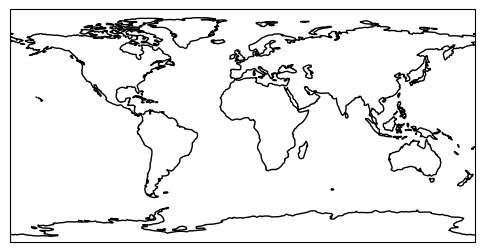

In [69]:
# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

for model in tqdm(models):
    for seas in seasons:
        depth=0
        levels=np.linspace(-10,10,11)
        #levels=np.linspace(-0,2000,11)
        var='clt'

        %matplotlib inline

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
        ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,zorder=3)


        data = ds_model[var,depth,seas,model].to_array(var).values[0]
        obsp = np.squeeze(ds_obs[var,depth,seas].to_array(var).values[0])
        #data_to_plot = data[0:90,:]-obsp[0:90,:]
        data_to_plot = obsp[0:90,:]

        lon = np.arange(0, 360, 2)
        lat = np.arange(-90, 90, 2)

        imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

        ax.set_title(model+' '+var+' '+depth+' '+seas,fontweight="bold")
        plt.tight_layout() 
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

        gl.xlabels_bottom = False    
        cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
        cbar_ax_abs.tick_params(labelsize=12)
        cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
        cb.ax.tick_params(labelsize='12')
        plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')


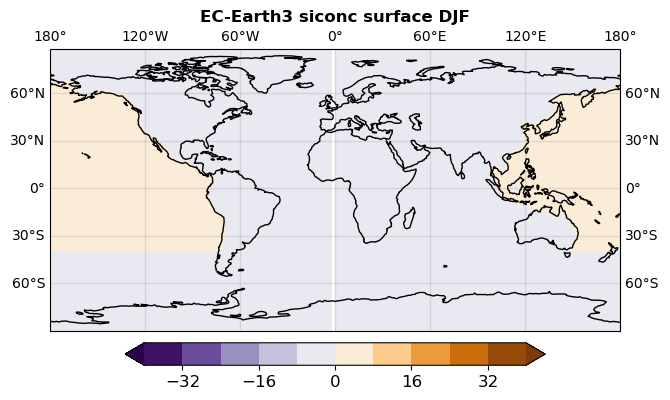

In [165]:



# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

model="EC-Earth3"

for seas in seasons:
    depth=0
    levels=np.linspace(-40,40,11)
    #levels=np.linspace(-0,2000,11)
    var='siconc'

    %matplotlib inline

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
    ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE,zorder=3)


    #data = np.squeeze(regions['Africa']['mask'])
    data = masks[9,:,:]

    #data_to_plot = data[0:90,:]-obsp[0:90,:]
    data_to_plot = data[0:90,:]

    lon = np.arange(0, 360, 2)
    lat = np.arange(-90, 90, 2)

    imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

    ax.set_title(model+' '+var+' '+depth+' '+seas,fontweight="bold")
    plt.tight_layout() 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
    cb.ax.tick_params(labelsize='12')
    plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')

In [ ]:
Mask available for: 0 Asia
Mask available for: 1 North_America
Mask available for: 2 Europe
Mask available for: 3 Africa
Mask available for: 4 South_America
Mask available for: 5 Oceania
Mask available for: 6 Australia
Mask available for: 7 Antarctica
Mask available for: 0 Atlantic_Basin
Mask available for: 1 Pacific_Basin
Mask available for: 2 Indian_Basin
Mask available for: 3 Arctic_Basin
Mask available for: 4 Southern_Ocean_Basin
Mask available for: 5 Mediterranean_Basin
Mask available for: 14 glob
Mask available for: 15 arctic
Mask available for: 16 northmid
Mask available for: 17 tropics
Mask available for: 18 innertropics
Mask available for: 19 nino34
Mask available for: 20 southmid
Mask available for: 21 antarctic